In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv


In [2]:
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv', parse_dates=['date'])
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
categories = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
submission = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')

In [3]:
train = pd.merge(train, items.drop('item_name', axis=1),on='item_id') #train.join(items.drop('item_name', axis=1), on=['item_id'])
train.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
2683522,2014-12-21,23,35,12194,499.0,2.0,30
2701341,2015-09-18,32,12,12193,1199.0,1.0,28
2046135,2013-12-13,11,26,17346,399.0,1.0,40
2408346,2014-10-27,21,42,4979,299.0,1.0,55
1358153,2013-02-05,4,57,17782,399.0,1.0,40


In [4]:
categories.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [5]:
def build_dict(o,t):
    l = []
    s,f = 0,0
    c = ""
    while f < len(t):
        while f < len(t) and not t[f].isalpha() :
            f += 1
        while f < len(t) and t[f] != "\'" :
            c += t[f]
            f += 1
        if c != "":
            l.append(c)
        c = ""
#     print(*zip(o,l), sep="\n")
    dic = dict(zip(o,l))
    return dic

t = '''
'PC - Headsets / Headphones' 'Accessories - PS2' 'Accessories - PS3'
 'Accessories - PS4' 'Accessories - PSP' 'Accessories - PSVita'
 'Accessories - XBOX 360' 'Accessories - XBOX ONE' 'Tickets (Digit)'
 '' Product delivery '' Game consoles - PS2 '' Game consoles - PS3 '
 'Game consoles - PS4' 'Game consoles - PSP'
 'Game consoles - PSVita' 'Game consoles - XBOX 360'
 'Game consoles - XBOX ONE' 'Game consoles - Other' 'Games - PS2'
 '' Games - PS3 '' Games - PS4 '' Games - PSP '' Games - PSVita '' Games - XBOX 360 '
 '' Games - XBOX ONE '' Games - Accessories for games' 'Android Games - Digit'
 'MAC Games - Digital' PC Games - Additional Editions'
 'PC Games - Collector's Editions' 'PC Games - Standard Editions'
 'PC Games - Digit' 'Payment cards (Cinema, Music, Games)'
 'Payment Cards - Live!' 'Payment Cards - Live! (Numeral)'
 'Payment Cards - PSN' 'Payment Cards - Windows (Digital)' 'Cinema - Blu-Ray'
 'Cinema - Blu-Ray 3D' 'Cinema - Blu-Ray 4K' 'Cinema - DVD'
 'Cinema - Collection' 'Books - Artbooks, Encyclopedias'
 'Books - Audiobooks' 'Books - Audiobooks (Digit)' 'Books - Audiobooks 1C'
 'Books - Business Literature' 'Books - Comics, Manga'
 'Books - Computer literature' 'Books - Methodological materials 1C'
 'Books - Postcards' 'Books - Cognitive literature'
 'Books - Guides' 'Books - Fiction'
 'Books - Digital' 'Music - Local Production CD'
 'Music - Corporate Production CD' 'Music - MP3' 'Music - Vinyl'
 'Music - Music Video' 'Music - Gift Editions'
 'Gifts - Attributes' 'Gifts - Gadgets, robots, sports'
 'Gifts - Soft Toys' 'Gifts - Board Games'
 'Gifts - Souvenirs (in bulk)'
 'Gifts - Bags, Albums, Mousepads' 'Gifts - Figures'
 'Programs - 1C: Enterprise 8' 'Programs - MAC (Digit)'
 'Programs - For home and office' 'Programs - For home and office (Digit)'
 'Programs - Educational' 'Programs - Educational (Numeral)' 'Utilities'
 'Service - Tickets' 'Net carriers (spire)'
 'Clean media (piece)' 'Batteries'
'''

dic = build_dict(list(categories.item_category_name.unique()), t)
categories.replace(dic, inplace=True)
categories.sample(5)

,item_category_name,item_category_id
81,Чистые носители (шпиль),81
50,Books - Methodological materials 1C,50
45,Books - Audiobooks (Digit),45
39,Cinema - Blu-Ray 3D,39
64,Gifts - Soft Toys,64


In [6]:
print(train.shape, test.shape)
print("train has all shops in test? ",set(test.shop_id.unique()).issubset(set(train.shop_id.unique())))
print("train has all items in test? ",set(test.item_id.unique()).issubset(set(train.item_id.unique())))
print("number of items in test is: ", len(set(test.item_id.unique())))
print("how many items in test are not in train? ", len(set(test.item_id.unique()).difference(set(train.item_id.unique()))) )
print("percent missing: ", len(set(test.item_id.unique()).difference(set(train.item_id.unique())))/len(set(test.item_id.unique()))*100)

(2935849, 7) (214200, 3)
train has all shops in test?  True
train has all items in test?  False
number of items in test is:  5100
how many items in test are not in train?  363
percent missing:  7.11764705882353


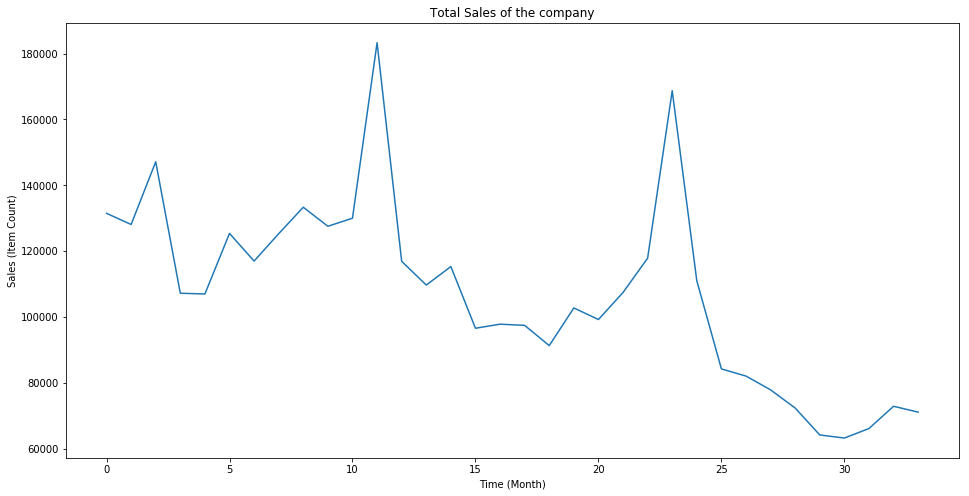

In [7]:
ts=train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time (Month)')
plt.ylabel('Sales (Item Count)')
plt.plot(ts);

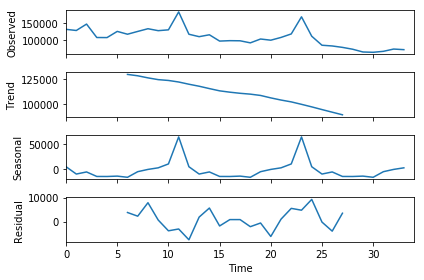

In [8]:
res = sm.tsa.seasonal_decompose(ts.values,freq=12) #,model="multiplicative")
res.plot();

In [9]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0484      2.962     -0.354      0.723      -6.854       4.757
ma.L1         -0.3043      1.466     -0.208      0.836      -3.177       2.569
ar.S.L12       0.4111      1.763      0.233      0.816      -3.045       3.867
sigma2      9.765e+07   6.77e-09   1.44e+16      0.000    9.76e+07    9.76e+07


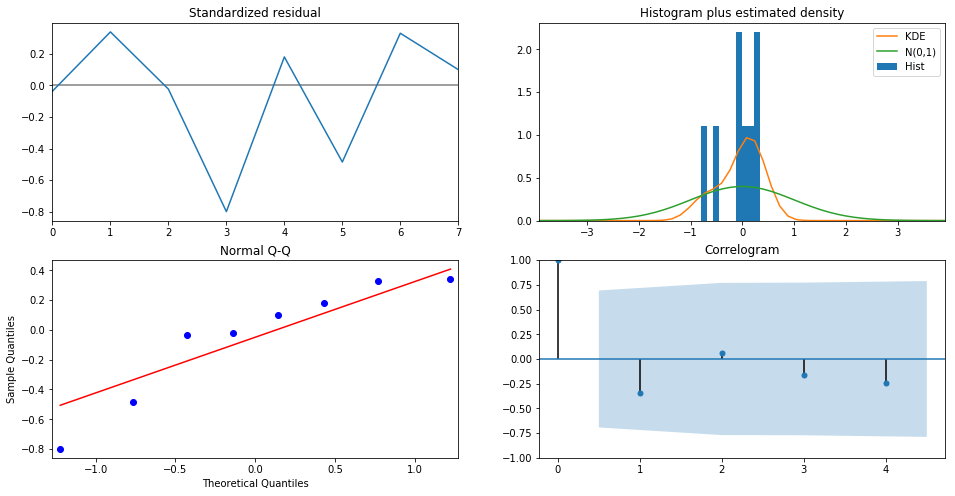

In [10]:
results.plot_diagnostics(lags=4, figsize=(16, 8)) #lags default at 10 is too much and cause acf plot error
plt.show()

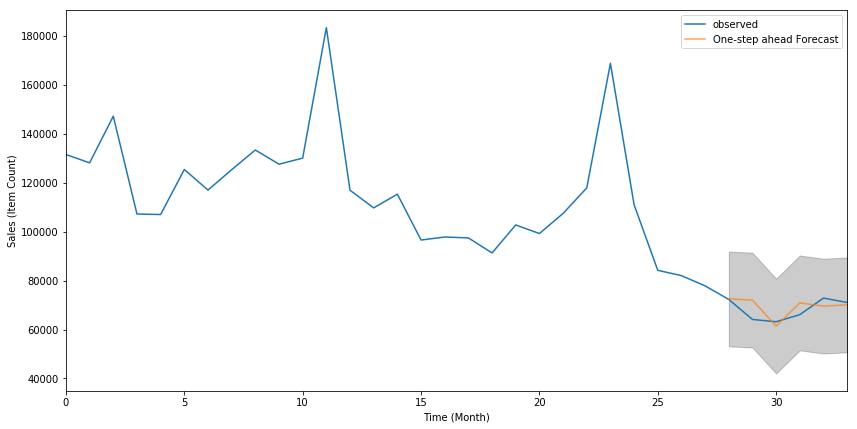

In [11]:
pred = results.get_prediction(start=28, dynamic=False)
pred_ci = pred.conf_int()
ax = ts.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Time (Month)')
ax.set_ylabel('Sales (Item Count)')
plt.legend()
plt.show()

In [12]:
y_forecasted = pred.predicted_mean
y_truth = ts[28:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 16681771.75
The Root Mean Squared Error of our forecasts is 4084.33


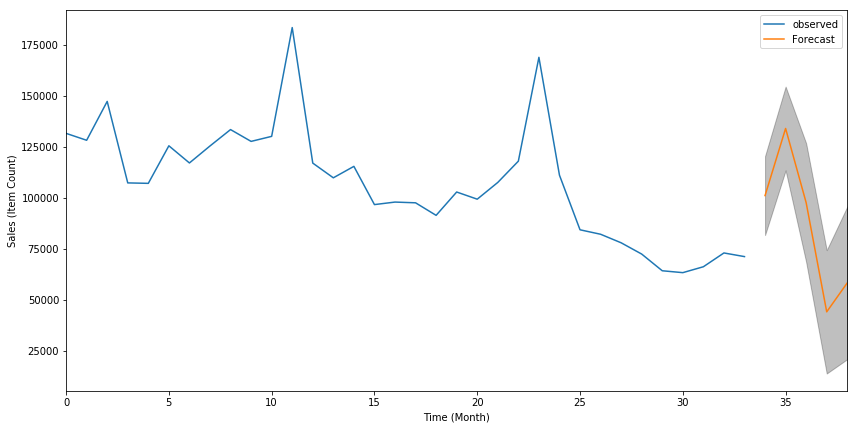

In [13]:
pred_uc = results.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time (Month)')
ax.set_ylabel('Sales (Item Count)')
plt.legend()
plt.show()

In [14]:
print(pred_ci,'\n', pred_ci.mean(axis=1))

    lower item_cnt_day  upper item_cnt_day
34        81601.935783       120337.486079
35       113341.345323       154415.128972
36        68368.885631       126595.830446
37        13741.252388        74211.829175
38        20774.783610        95593.487844 
 34    100969.710931
35    133878.237148
36     97482.358039
37     43976.540781
38     58184.135727
dtype: float64


In [15]:
predicted_sale = pred_ci.iloc[0].mean()
last_month_sale = ts.iloc[-1]
last_year_sale = ts.iloc[-12]
print(last_month_sale, last_year_sale, predicted_sale)
rlm = predicted_sale/last_month_sale
rly = predicted_sale/last_year_sale
print(rlm, rly)

71056.0 117845.0 100969.71093084232
1.4209878255297557 0.8568009752712659


if shop-item is never seen in train, shop-item = (last year shop-category.mode or last month shop-category.mode) * ratio;

if shop-item was not seen a year ago, shop-item = last month shop-item * ratio

shop-item = last year shop-item * ratio

In [16]:
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
print('test shape before ', test.shape)
test = pd.merge(test, items.drop('item_name', axis=1),on='item_id') #train.join(items.drop('item_name', axis=1), on=['item_id'])
print('test shape after ', test.shape)
test.head(5)

test shape before  (214200, 3)
test shape after  (214200, 4)


,ID,shop_id,item_id,item_category_id
0,0,5,5037,19
1,5100,4,5037,19
2,10200,6,5037,19
3,15300,3,5037,19
4,20400,2,5037,19


In [17]:
monthly_sale_shop_item = train.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
monthly_sale_shop_item.head()

shop_id  item_id  date_block_num
0        30       1                 31.0
         31       1                 11.0
         32       0                  6.0
                  1                 10.0
         33       0                  3.0
Name: item_cnt_day, dtype: float64

In [18]:
monthly_sale_shop_item = monthly_sale_shop_item.reset_index()
monthly_sale_shop_item.head()

,shop_id,item_id,date_block_num,item_cnt_day
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0


In [19]:
last_month_shop_item = monthly_sale_shop_item[monthly_sale_shop_item['date_block_num'] == 33]
last_month_shop_item.head()

,shop_id,item_id,date_block_num,item_cnt_day
8113,2,31,33,1.0
8205,2,486,33,3.0
8254,2,787,33,1.0
8284,2,794,33,1.0
8367,2,968,33,1.0


In [20]:
last_year_shop_item = monthly_sale_shop_item[monthly_sale_shop_item['date_block_num'] == 22]
last_year_shop_item.head()

,shop_id,item_id,date_block_num,item_cnt_day
8199,2,486,22,2.0
8213,2,491,22,1.0
8300,2,806,22,1.0
8346,2,949,22,1.0
8355,2,950,22,1.0


In [21]:
ttest = pd.merge(test, last_month_shop_item.drop('date_block_num', axis=1),on=['shop_id','item_id'], how='left')
print(ttest.shape)
ttest.head(5)

(214200, 5)


,ID,shop_id,item_id,item_category_id,item_cnt_day
0,0,5,5037,19,NaN
1,5100,4,5037,19,NaN
2,10200,6,5037,19,1.0
3,15300,3,5037,19,NaN
4,20400,2,5037,19,NaN


In [22]:
ttest = pd.merge(ttest, last_year_shop_item.drop('date_block_num', axis=1),on=['shop_id','item_id'], suffixes=('_33', '_22'), how='left') 
print(ttest.shape)
ttest.head(5)

(214200, 6)


,ID,shop_id,item_id,item_category_id,item_cnt_day_33,item_cnt_day_22
0,0,5,5037,19,NaN,1.0
1,5100,4,5037,19,NaN,NaN
2,10200,6,5037,19,1.0,4.0
3,15300,3,5037,19,NaN,2.0
4,20400,2,5037,19,NaN,NaN


In [23]:
ttest.isnull().sum()

ID                       0
shop_id                  0
item_id                  0
item_category_id         0
item_cnt_day_33     185520
item_cnt_day_22     191772
dtype: int64

In [24]:
cat_sale = ttest.groupby(['shop_id', 'item_category_id'])['item_cnt_day_33'].apply(lambda x: x.mode(dropna=True))
cat_sale = cat_sale.reset_index()
print(cat_sale.shape)
cat_sale.head()

(1919, 4)


,shop_id,item_category_id,level_2,item_cnt_day_33
0,2,3,0,1.0
1,2,6,0,1.0
2,2,6,1,3.0
3,2,6,2,4.0
4,2,7,0,1.0


In [25]:
cat_sale.rename(columns={'level_2':'shop_cat_mode'}, 
                 inplace=True)
cat_sale.head()

,shop_id,item_category_id,shop_cat_mode,item_cnt_day_33
0,2,3,0,1.0
1,2,6,0,1.0
2,2,6,1,3.0
3,2,6,2,4.0
4,2,7,0,1.0


In [26]:
print(ttest.shape)
ttest = pd.merge(ttest, cat_sale.drop('item_cnt_day_33', axis=1),on=['shop_id','item_category_id'], how='left') 
print(ttest.shape)
ttest.head(5)

(214200, 6)
(217543, 7)


,ID,shop_id,item_id,item_category_id,item_cnt_day_33,item_cnt_day_22,shop_cat_mode
0,0,5,5037,19,NaN,1.0,0.0
1,5100,4,5037,19,NaN,NaN,0.0
2,10200,6,5037,19,1.0,4.0,0.0
3,15300,3,5037,19,NaN,2.0,0.0
4,20400,2,5037,19,NaN,NaN,0.0


In [27]:
ttest.isnull().sum()

ID                       0
shop_id                  0
item_id                  0
item_category_id         0
item_cnt_day_33     187941
item_cnt_day_22     194333
shop_cat_mode        35877
dtype: int64

In [28]:
ttest['shop_cat_mode'].value_counts(dropna=False)

0.0    178323
NaN     35877
1.0      2992
2.0       247
3.0        72
7.0         8
5.0         8
6.0         8
4.0         8
Name: shop_cat_mode, dtype: int64